# **Imports & Dataset Loading**

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fossee-xarray-dataset/element.py
/kaggle/input/fossee-xarray-dataset/screening_task.nc
/kaggle/input/fossee-xarray-dataset/node.py


In [39]:
import xarray as xr

ds = xr.open_dataset("/kaggle/input/fossee-xarray-dataset/screening_task.nc")
print(ds)

<xarray.Dataset> Size: 21kB
Dimensions:    (Element: 85, Component: 30)
Coordinates:
  * Element    (Element) int32 340B 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
  * Component  (Component) object 240B 'Mx_i' 'Mx_j' 'My_i' ... 'x' 'y' 'z'
    Loadcase   object 8B ...
Data variables:
    forces     (Element, Component) float64 20kB ...


Figuring out the dataset

In [40]:
component = ds['Component']
print(component)

<xarray.DataArray 'Component' (Component: 30)> Size: 240B
array(['Mx_i', 'Mx_j', 'My_i', 'My_j', 'Mz_i', 'Mz_j', 'Vx_i', 'Vx_j', 'Vy_i',
       'Vy_j', 'Vz_i', 'Vz_j', 'ddtheta_x', 'ddtheta_y', 'ddtheta_z', 'ddx',
       'ddy', 'ddz', 'dtheta_x', 'dtheta_y', 'dtheta_z', 'dx', 'dy', 'dz',
       'theta_x', 'theta_y', 'theta_z', 'x', 'y', 'z'], dtype=object)
Coordinates:
  * Component  (Component) object 240B 'Mx_i' 'Mx_j' 'My_i' ... 'x' 'y' 'z'
    Loadcase   object 8B ...


In [41]:
list(ds.data_vars)

['forces']

In [42]:
var = ds["forces"]
print(var.dims)

('Element', 'Component')


# **Task 1: Central Girder(2D BMD & SFD)**

Extracting the Bending Moment(Mz_i and Mz_j) and Shear Force(Vy_i and Vy_j)

In [43]:
mz_i = var.sel(Component = "Mz_i")
mz_j = var.sel(Component = "Mz_j")
vy_i = var.sel(Component = "Vy_i")
vy_j = var.sel(Component = "Vy_i")

Checking if accessed correctly

In [44]:
print(mz_i)
print(mz_i.dims)

<xarray.DataArray 'forces' (Element: 85)> Size: 680B
[85 values with dtype=float64]
Coordinates:
  * Element    (Element) int32 340B 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
    Component  <U4 16B 'Mz_i'
    Loadcase   object 8B ...
('Element',)


Extracting BM and SF values for the central girder

In [45]:
central_girder = [15,24,33,42,51,60,69,78,83]

In [46]:
mz_i_c = mz_i.sel(Element = central_girder)
mz_j_c = mz_j.sel(Element = central_girder)

vy_i_c = vy_i.sel(Element = central_girder)
vy_j_c = vy_j.sel(Element = central_girder)

Checking the values

In [47]:
print(mz_i_c)
print(mz_i_c.coords["Element"].values)

<xarray.DataArray 'forces' (Element: 9)> Size: 72B
[9 values with dtype=float64]
Coordinates:
  * Element    (Element) int32 36B 15 24 33 42 51 60 69 78 83
    Component  <U4 16B 'Mz_i'
    Loadcase   object 8B ...
[15 24 33 42 51 60 69 78 83]


Adding the values to respective lists

In [48]:
bmd = []
sfd = []

bmd.append(mz_i_c.values[0])
sfd.append(vy_i_c.values[0])

for i in range(len(central_girder)):
    bmd.append(mz_j_c.values[i])
    sfd.append(vy_j_c.values[i])

Checking the lists

In [49]:
print("BMD = ", bmd)
print("SFD = ", sfd)

BMD =  [np.float64(1.1901590823981678e-13), np.float64(-6.326409811754969), np.float64(-13.103262990249593), np.float64(-20.434362938017554), np.float64(-22.989483648428113), np.float64(-17.475308151452275), np.float64(-13.145606291454381), np.float64(-8.882924249789717), np.float64(-4.3080849261230245), np.float64(-1.3145040611561853e-13)]
SFD =  [np.float64(-2.2774893123172473), np.float64(-2.2774893123172473), np.float64(-2.4396476270771905), np.float64(-2.6392698807535746), np.float64(-0.9198360970594556), np.float64(1.9850872982130034), np.float64(1.5586802001578608), np.float64(1.5346085040375836), np.float64(1.6469289810880918), np.float64(1.550898166218835)]


Checking the continuity of BMD

In [50]:
print("-----------BMD Values----------")
for i in range(len(central_girder)-1):
    diff_mz = mz_j_c.values[i] - mz_i_c.values[i+1]
    print(f"BMD Difference {i}:, {diff_mz:.3e}")
print("-----------SFD Values----------")
for j in range(len(central_girder)-1):
    diff_vy = vy_j_c.values[j] - vy_i_c.values[j+1]
    print(f"SFD Difference {j}:, {diff_vy:.3e}")

-----------BMD Values----------
BMD Difference 0:, -1.265e+01
BMD Difference 1:, -2.621e+01
BMD Difference 2:, -4.087e+01
BMD Difference 3:, -4.598e+01
BMD Difference 4:, -3.495e+01
BMD Difference 5:, -2.629e+01
BMD Difference 6:, -1.777e+01
BMD Difference 7:, -8.616e+00
-----------SFD Values----------
SFD Difference 0:, 1.622e-01
SFD Difference 1:, 1.996e-01
SFD Difference 2:, -1.719e+00
SFD Difference 3:, -2.905e+00
SFD Difference 4:, 4.264e-01
SFD Difference 5:, 2.407e-02
SFD Difference 6:, -1.123e-01
SFD Difference 7:, 9.603e-02


Using x being index based axis

In [51]:
x = list(range(len(bmd)))

Plotting the final BMD

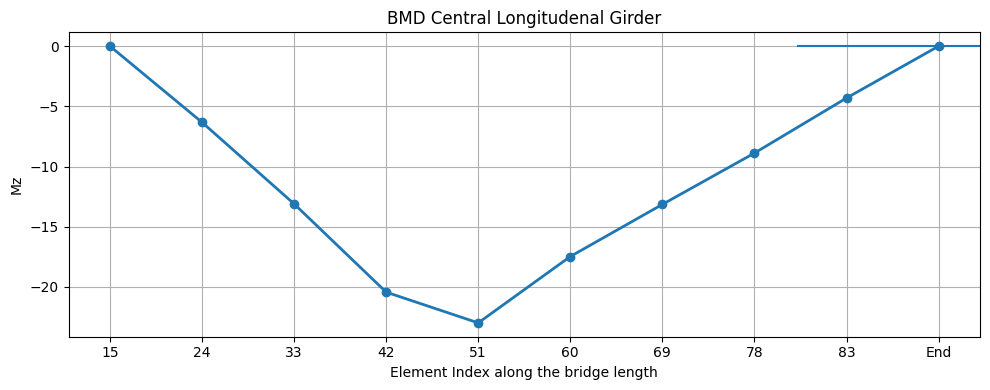

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))
plt.plot(x, bmd, marker = 'o', linewidth = 2)
plt.axhline(0, 0.8)
plt.grid(True)

x_labels = ["15", "24", "33", "42", "51", "60", "69", "78", "83", "End"]
plt.xticks(x, x_labels)

plt.title("BMD Central Longitudenal Girder")
plt.xlabel("Element Index along the bridge length")
plt.ylabel("Mz")

plt.tight_layout()
plt.show()

Plotting the final SFD

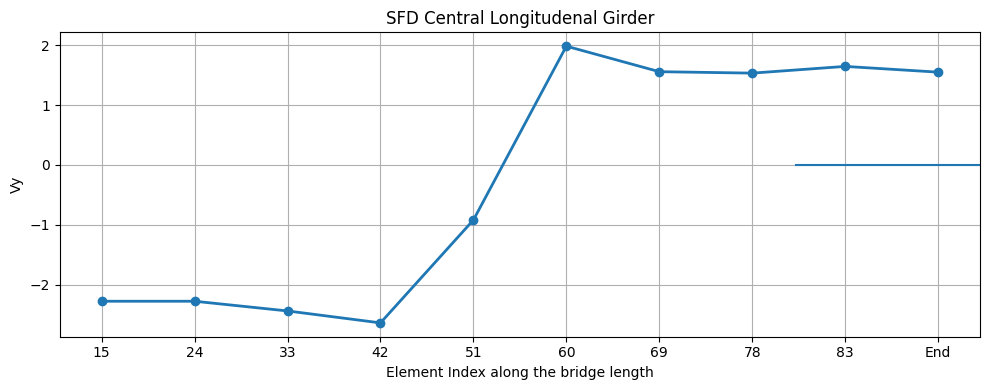

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))
plt.plot(x, sfd, marker = 'o', linewidth = 2)
plt.axhline(0, 0.8)
plt.grid(True)

x_labels = ["15", "24", "33", "42", "51", "60", "69", "78", "83", "End"]
plt.xticks(x, x_labels)

plt.title("SFD Central Longitudenal Girder")
plt.xlabel("Element Index along the bridge length")
plt.ylabel("Vy")

plt.tight_layout()
plt.show()

# **Task 2: Geometry Setup (Nodes and Members)**

Adding the given nodes and elements dataset

In [54]:
# Define the path to your .py file
file_node = '/kaggle/input/fossee-xarray-dataset/node.py'
file_element = '/kaggle/input/fossee-xarray-dataset/element.py'


# Read the contents of the file
with open(file_node, 'r') as f1:
    script_content_node = f1.read()

with open(file_element, 'r') as f2:
    script_content_element = f2.read()

# Execute the script content
# Note: exec() runs the code in the current scope
exec(script_content_node)
exec(script_content_element)

In [55]:
#Checking the contents of the dataset
print(script_content_node)
print(script_content_element)

# Node coordinates: node_id : [x, y, z]
nodes = {
    1: [0.0000, 0.0000, 0.0000],
    2: [0.0000, 0.0000, 1.2000],
    3: [0.0000, 0.0000, 5.1750],
    4: [0.0000, 0.0000, 9.1500],
    5: [0.0000, 0.0000, 10.3500],
    6: [25.0000, 0.0000, 0.0000],
    7: [25.0000, 0.0000, 1.2000],
    8: [25.0000, 0.0000, 5.1750],
    9: [25.0000, 0.0000, 9.1500],
    10: [25.0000, 0.0000, 10.3500],
    11: [2.7778, 0.0000, 0.0000],
    12: [2.7778, 0.0000, 1.2000],
    13: [2.7778, 0.0000, 5.1750],
    14: [2.7778, 0.0000, 9.1500],
    15: [2.7778, 0.0000, 10.3500],
    16: [5.5556, 0.0000, 0.0000],
    17: [5.5556, 0.0000, 1.2000],
    18: [5.5556, 0.0000, 5.1750],
    19: [5.5556, 0.0000, 9.1500],
    20: [5.5556, 0.0000, 10.3500],
    21: [8.3333, 0.0000, 0.0000],
    22: [8.3333, 0.0000, 1.2000],
    23: [8.3333, 0.0000, 5.1750],
    24: [8.3333, 0.0000, 9.1500],
    25: [8.3333, 0.0000, 10.3500],
    26: [11.1111, 0.0000, 0.0000],
    27: [11.1111, 0.0000, 1.2000],
    28: [11.1111, 0.0000, 5.1

In [20]:
# Checking whether exec() worked
# print(type(nodes))
# print(type(members))

<class 'dict'>
<class 'dict'>


**Testing the concept on a single girder**

In [56]:
girder3_elements = [15, 24, 33, 42, 51, 60, 69, 78, 83]

girder3_nodes = []

for ele in girder3_elements:
    ni, nj = members[ele]
    if not girder3_nodes:
        girder3_nodes.append(ni)
    girder3_nodes.append(nj)

print(girder3_nodes)

[3, 13, 18, 23, 28, 33, 38, 43, 48, 8]


Extracting node coordinates

In [57]:
x = []
z = []

for n in girder3_nodes:
    xn, yn, zn = nodes[n]
    x.append(xn)
    z.append(zn)

Building force values at nodes for the central girder(Girder 3)

In [58]:
mz_vals = []

mz_vals.append(float(mz_i.sel(Element = girder3_nodes[0]).values))

for e in girder3_elements:
    mz_vals.append(float(mz_i.sel(Element = e).values))

In [59]:
#Checking if the number of values are equal
len(x), len(z), len(mz_vals)

(10, 10, 10)

Final Plotting for the Central Girder (Girder 3)

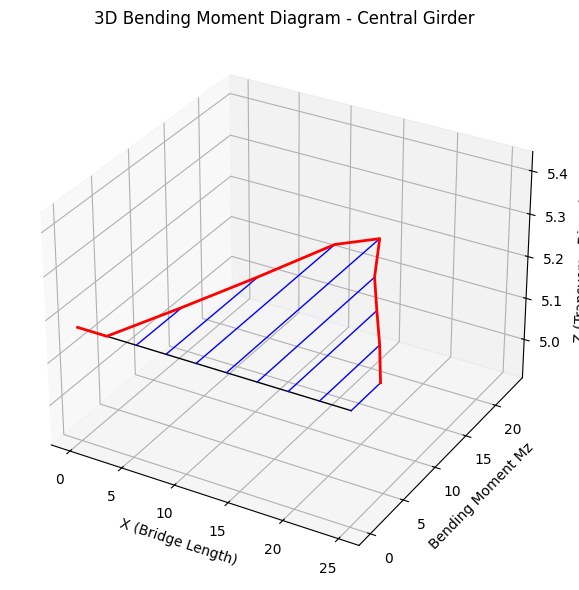

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111, projection = "3d")

#Base Girder Geometry on y=0 plane
ax.plot(x, [0]*len(x), z, color = "black", linewidth = 1)

for xi, zi, mi in zip(x, z, mz_vals):
    ax.plot([xi,xi], [0,mi], [zi,zi], color = "blue", linewidth = 1)

ax.plot(x, mz_vals, z, color = "red", linewidth = 2)

ax.set_xlabel("X (Bridge Length)")
ax.set_ylabel("Bending Moment Mz")
ax.set_zlabel("Z (Transverse Direction)")

ax.set_title("3D Bending Moment Diagram - Central Girder")

plt.tight_layout()
plt.show()

# **Task 2: 3D BMD (All Girders)**

In [61]:
girders = {
    "G1":[13, 22, 31, 40, 49, 58, 67, 76, 81],
    "G2":[14, 23, 32, 41, 50, 59, 68, 77, 82],
    "G3":[15, 24, 33, 42, 51, 60, 69, 78, 83],    #Central One
    "G4":[16, 25, 34, 43, 52, 61, 70, 79, 84],
    "G5":[17, 26, 35, 44, 53, 62, 71, 80, 85]
}

Building the respective helper functions from the example taken above

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def build_nodes_from_elements(element_list, members):
    node_list = []
    for ele in element_list:
        ni, nj = members[ele]
        if not node_list:
            node_list.append(ni)
        node_list.append(nj)
    return node_list

def get_xz(node_list, nodes):
    x = []
    z = []
    for n in node_list:
        xn, yn, zn = nodes[n]
        x.append(xn)
        z.append(zn)
    return x, z

def build_node_forces(elements, f_i, f_j):
    vals = []
    vals.append(float(f_i.sel(Element = elements[0]).values))
    for e in girder3_elements:
        vals.append(float(f_j.sel(Element = e).values))
    return vals

def plot_base_geometry(ax, nodes, members):
    for _, (ni, nj) in members.items():
        xi, yi, zi = nodes[ni]
        xj, yj, zj = nodes[nj]
        ax.plot([xi, xj], [0, 0], [zi, zj], color = "lightgrey", linewidth = 0.6)

Implementing the functions as per the need on all the girders for BMD

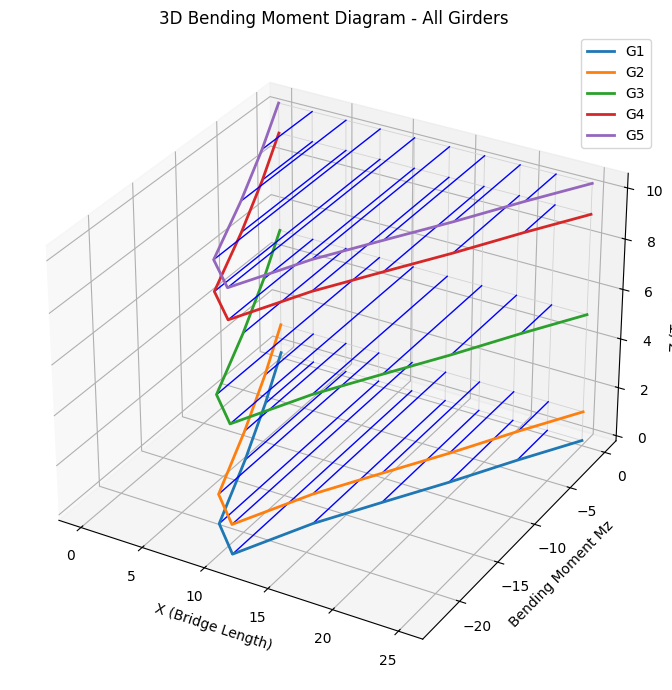

In [63]:
fig = plt.figure(figsize = (12, 7))
ax = fig.add_subplot(111, projection = "3d")

plot_base_geometry(ax, nodes, members)

for name, elems in girders.items():
    node_list = build_nodes_from_elements(elems, members)
    x, z = get_xz(node_list, nodes)
    mz_vals = build_node_forces(elems, mz_i, mz_j)

    for xi, zi, mi in zip(x, z, mz_vals):
        ax.plot([xi, xi], [0, mi], [zi, zi], color = "blue", linewidth = 1)

    ax.plot(x, mz_vals, z, linewidth = 2, label = name)

ax.set_xlabel("X (Bridge Length)")
ax.set_ylabel("Bending Moment Mz")
ax.set_zlabel("Z (Transverse)")
ax.set_title("3D Bending Moment Diagram - All Girders")

ax.legend()
plt.tight_layout()
plt.show()

# **Task 2: 3D SFD (All Girders)**

Justing changing the forces in the above code fot SFD

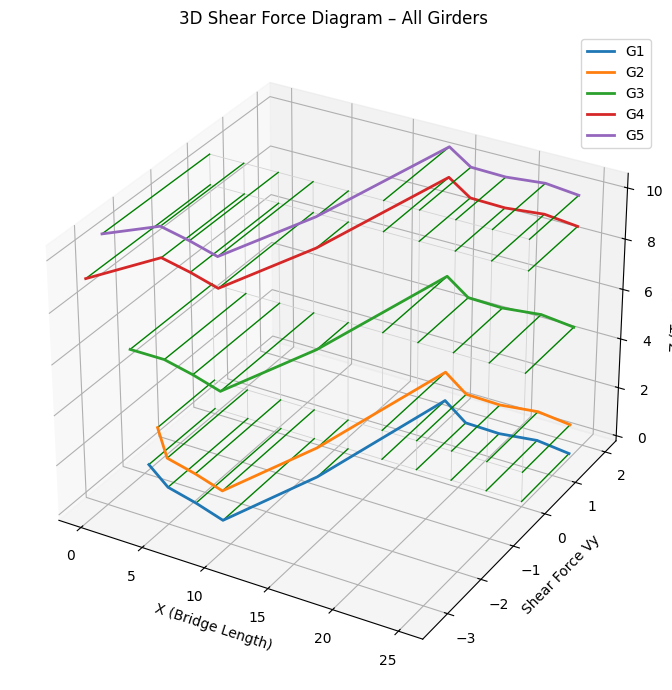

In [64]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection="3d")

# Base structure
plot_base_geometry(ax, nodes, members)

# Plot each girder
for name, elems in girders.items():
    node_list = build_nodes_from_elements(elems, members)
    x, z = get_xz(node_list, nodes)
    vy_vals = build_node_forces(elems, vy_i, vy_j)

    # Vertical extrusion
    for xi, zi, vi in zip(x, z, vy_vals):
        ax.plot([xi, xi], [0, vi], [zi, zi],
                color="green", linewidth=1)

    # Top curve
    ax.plot(x, vy_vals, z, linewidth=2, label=name)

ax.set_xlabel("X (Bridge Length)")
ax.set_ylabel("Shear Force Vy")
ax.set_zlabel("Z (Transverse)")
ax.set_title("3D Shear Force Diagram – All Girders")

ax.legend()
plt.tight_layout()
plt.show()